In [1]:
import os
import time
import warnings
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from rich import print
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    learning_curve
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import cross_val_score


%load_ext rich
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
path ="spotify_songs_train.csv"

In [3]:
def prepare_data(data, date_column='track_album_release_date', target='track_popularity', test_size=0.2):
  
    data[date_column] = pd.to_datetime(data[date_column], errors='coerce')
    not_null_mask = data[date_column].dt.month.notnull() & data[date_column].dt.day.notnull()
    data = data[not_null_mask]
    data = data.dropna()
    X = data.drop(columns=[target])
    y = (data[target] > 50).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test


data = pd.read_csv(path)  
X_train, X_test, y_train, y_test = prepare_data(data)

In [4]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 23636

Test set size: 5909

## Feature engineering


In [5]:
class TopArtistTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_artists=10):
        self.num_top_artists = num_top_artists
        self.top_artists = None

    def fit(self, X, y=None):
        X["release_date__year"] = pd.to_datetime(
            X["track_album_release_date"], errors="coerce"
        ).dt.year
        songs_last_decade = X[
            X["release_date__year"] >= X["release_date__year"].max() - 10
        ]

        top_artists = (
            songs_last_decade.groupby("track_artist")
            .agg({"track_id": "count"})
            .rename(
                columns={
                    "track_id": "number_of_tracks",
                }
            )
        )

        top_artists = top_artists.sort_values(
            ["number_of_tracks"], ascending=[False]
        ).head(self.num_top_artists)

        self.top_artists = top_artists.index

        return self

    def transform(self, X):
        is_top_artist = X["track_artist"].isin(self.top_artists)
        return is_top_artist.to_frame(name="is_top_artist")

    def get_feature_names_out(self, input_features=None):
        return ["is_top_artist"]

In [6]:
def get_num_playlists(X):
    num_playlist = X.groupby("track_id")["playlist_id"].transform("nunique").values

    return np.column_stack([num_playlist])


def playlist_name(X, feature_names):
    return ["num_playlists"]


def release_date(X):
    X = pd.to_datetime(X, errors="coerce")

    month = X.dt.month
    day = X.dt.day

    month_season = month.map(
        {
            1: "Winter",
            2: "Winter",
            3: "Spring",
            4: "Spring",
            5: "Spring",
            6: "Summer",
            7: "Summer",
            8: "Summer",
            9: "Fall",
            10: "Fall",
            11: "Fall",
            12: "Winter",
        }
    )

    day_category = pd.cut(day, bins=[0, 10, 20, 31], labels=["First 10", "Middle 10", "Last 10"], right=False)

    return np.column_stack([month_season, day_category])


def release_date_name(X, feature_names):
    return ["month_season", "day_category"]


def get_is_remix_or_collab(X):
    is_remix = X.str.contains("remix", case=False).astype(int)
    is_collab = X.str.contains(r"(feat|ft\.|\(with)", case=False).astype(int)
    return np.column_stack([is_remix, is_collab])


def is_remix_or_collab_name(X, feature_names):
    return ["is_remix", "is_collab"]


def get_is_weekend(X):
    X = pd.to_datetime(X, errors="coerce")
    return X.dt.dayofweek.isin([5, 6]).astype(int).values.reshape(-1, 1)


def is_weekend_name(X, feature_names):
    return ["is_weekend"]


num_playlist_pipeline = make_pipeline(
    FunctionTransformer(
        get_num_playlists,
        validate=False,
        feature_names_out=playlist_name,
    ),
    StandardScaler(),
)

release_date_pipeline = make_pipeline(
    FunctionTransformer(
        release_date, validate=False, feature_names_out=release_date_name
    ),
    OneHotEncoder(handle_unknown="ignore"),
)

num_pipeline = make_pipeline(
    StandardScaler(),
)


feature_engineering = ColumnTransformer(
    [
        # (
        #     "num_playlists",
        #     num_playlist_pipeline,
        #     ["track_id", "playlist_id"],
        # ),
        (
            "release_date",
            release_date_pipeline,
            "track_album_release_date",
        ),
        (
            "release_day",
            FunctionTransformer(
                get_is_weekend, validate=False, feature_names_out=is_weekend_name
            ),
            "track_album_release_date",
        ),
        (
            "top_artist",
            TopArtistTransformer(num_top_artists=50),
            [
                "track_artist",
                "track_album_release_date",
                "track_id",
            ],
        ),
        (
            "genres",
            OneHotEncoder(handle_unknown="ignore"),
            ["playlist_genre", "playlist_subgenre"],
        ),
        (
            "track_name",
            FunctionTransformer(
                get_is_remix_or_collab,
                validate=False,
                feature_names_out=is_remix_or_collab_name,
            ),
            "track_name",
        ),
        (
            "numerical",
            num_pipeline,
            [
                "danceability",
                "energy",
                "loudness",
                "speechiness",
                "acousticness",
                "instrumentalness",
                "liveness",
                "valence",
                "tempo",
                "duration_ms",
            ],
        ),
        (
            "key",
            OrdinalEncoder(),
            ["key"],
        ),
        ("mode", "passthrough", ["mode"]),
    ],
    remainder="drop",
)

In [7]:
feature_engineering.fit(X_train)
with open('feature_engineering.pkl', 'wb') as f:
    pickle.dump(feature_engineering, f)

with open('train_test_data.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)


### Unit Test

In [8]:
import unittest
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
class TestTopArtistTransformer(unittest.TestCase):
    def setUp(self):
        # Sample data
        self.data = pd.DataFrame({
            'track_album_release_date': ['2010-01-01', '2011-05-01', '2020-01-01', '2020-01-02', '2019-01-01'],
            'track_artist': ['Artist1', 'Artist1', 'Artist2', 'Artist3', 'Artist2'],
            'track_id': [1, 2, 3, 4, 5]
        })
        self.transformer = TopArtistTransformer(num_top_artists=2)

    def test_fit(self):
    # Test the fitting process
        self.transformer.fit(self.data)
        self.assertEqual(len(self.transformer.top_artists), 2)
        self.assertIn('Artist2', self.transformer.top_artists)
        self.assertIn('Artist1', self.transformer.top_artists)

    def test_transform(self):
        # Fit and then transform the data
        self.transformer.fit(self.data)
        transformed = self.transformer.transform(self.data)
        expected = pd.DataFrame({
            'is_top_artist': [True, True, True, False, True]
        })
        pd.testing.assert_frame_equal(transformed, expected)

    def test_feature_names_out(self):
        # Check the output feature names
        output_names = self.transformer.get_feature_names_out()
        self.assertEqual(output_names, ['is_top_artist'])


suite = unittest.TestLoader().loadTestsFromTestCase(TestTopArtistTransformer)
unittest.TextTestRunner().run(suite)



...
----------------------------------------------------------------------
Ran 3 tests in 0.015s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [9]:
class TestFeatureTransformations(unittest.TestCase):

    def test_get_num_playlists(self):

        data = pd.DataFrame({
            'track_id': ['t1', 't1', 't2', 't3', 't3'],
            'playlist_id': ['p1', 'p2', 'p1', 'p1', 'p2']
        })
        expected_result = np.array([[2], [2], [1], [2], [2]])  # Expect each track to count unique playlists
        result = get_num_playlists(data)
        np.testing.assert_array_equal(result, expected_result)

    def test_release_date(self):
        data = pd.Series(['2021-03-01', '2021-06-15', '2021-09-15'])
        expected_result = np.array([['Spring', 'First 10'], ['Summer', 'Middle 10'], ['Fall', 'Middle 10']])
        result = release_date(data)
        np.testing.assert_array_equal(result, expected_result)


    def test_get_is_remix_or_collab(self):
        data = pd.Series(['song remix', 'artist feat. guest', 'normal song'])
        expected_result = np.array([[1, 0], [0, 1], [0, 0]])
        result = get_is_remix_or_collab(data)
        np.testing.assert_array_equal(result, expected_result)

    def test_get_is_weekend(self):
        data = pd.Series(['2021-03-06', '2021-03-07', '2021-03-08'])  # Saturday, Sunday, Monday
        expected_result = np.array([[1], [1], [0]])
        result = get_is_weekend(data)
        np.testing.assert_array_equal(result, expected_result)

suite = unittest.TestLoader().loadTestsFromTestCase(TestFeatureTransformations)
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.016s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

## Model building


In [10]:
# Apply the feature engineering pipeline on the training data
X_train_transformed = feature_engineering.fit_transform(X_train)
X_test_transformed = feature_engineering.transform(X_test)

# Convert to DataFrames and ensure indices match with original training and testing sets
X_train_transformed_df = pd.DataFrame(X_train_transformed, index=X_train.index, columns=feature_engineering.get_feature_names_out())
X_test_transformed_df = pd.DataFrame(X_test_transformed, index=X_test.index, columns=feature_engineering.get_feature_names_out())


In [11]:
# Sample 4000 entries from the training set and 100 from the testing set as an example
n_train_samples = 4000
n_test_samples = 1000

# Use random state for reproducibility
X_train_transformed = X_train_transformed_df.sample(n=n_train_samples, random_state=42)
y_train = y_train.loc[X_train_transformed.index]  

X_test_transformed = X_test_transformed_df.sample(n=n_test_samples, random_state=42)
y_test = y_test.loc[X_test_transformed.index] 

feature_dtypes = X_train_transformed.dtypes
print(feature_dtypes)


release_date__month_season_Fall                        float64
release_date__month_season_Spring                      float64
release_date__month_season_Summer                      float64
release_date__month_season_Winter                      float64
release_date__day_category_First 10                    float64
release_date__day_category_Last 10                     float64
release_date__day_category_Middle 10                   float64
release_date__day_category_nan                         float64
release_day__is_weekend                                float64
top_artist__is_top_artist                              float64
genres__playlist_genre_edm                             float64
genres__playlist_genre_latin                           float64
genres__playlist_genre_pop                             float64
genres__playlist_genre_r&b                             float64
genres__playlist_genre_rap                             float64
genres__playlist_genre_rock                            float64
genres__playlist_subgenre_album rock                   float64
genres__playlist_subgenre_big room                     float64
genres__playlist_subgenre_classic rock                 float64
genres__playlist_subgenre_dance pop                    float64
genres__playlist_subgenre_electro house                float64
genres__playlist_subgenre_electropop                   float64
genres__playlist_subgenre_gangster rap                 float64
genres__playlist_subgenre_hard rock                    float64
genres__playlist_subgenre_hip hop                      float64
genres__playlist_subgenre_hip pop                      float64
genres__playlist_subgenre_indie poptimism              float64
genres__playlist_subgenre_latin hip hop                float64
genres__playlist_subgenre_latin pop                    float64
genres__playlist_subgenre_neo soul                     float64
genres__playlist_subgenre_new jack swing               float64
genres__playlist_subgenre_permanent wave               float64
genres__playlist_subgenre_pop edm                      float64
genres__playlist_subgenre_post-teen pop                float64
genres__playlist_subgenre_progressive electro house    float64
genres__playlist_subgenre_reggaeton                    float64
genres__playlist_subgenre_southern hip hop             float64
genres__playlist_subgenre_trap                         float64
genres__playlist_subgenre_tropical                     float64
genres__playlist_subgenre_urban contemporary           float64
track_name__is_remix                                   float64
track_name__is_collab                                  float64
numerical__danceability                                float64
numerical__energy                                      float64
numerical__loudness                                    float64
numerical__speechiness                                 float64
numerical__acousticness                                float64
numerical__instrumentalness                            float64
numerical__liveness                                    float64
numerical__valence                                     float64
numerical__tempo                                       float64
numerical__duration_ms                                 float64
key__key                                               float64
mode__mode                                             float64
dtype: object

## Optuna Optimization Combined

In [13]:
def objective(trial, classifier_name, X_train, y_train):
    if classifier_name == 'KNN':
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 1, 50),
            p=trial.suggest_int('p', 1, 2),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance'])
        )

    elif classifier_name == 'RandomForest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            max_depth=trial.suggest_int('max_depth', 10, 100),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 8),
            random_state=42
        )

    elif classifier_name == 'GaussianNB':
        model = GaussianNB(
            var_smoothing=trial.suggest_float('var_smoothing', 1e-10, 1e-8, log=True)
        )

    elif classifier_name == 'GradientBoosting':
        model = GradientBoostingClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
            random_state=42
        )

    elif classifier_name == 'DecisionTree':
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 32),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            random_state=42
        )

    elif classifier_name == 'LGBM':
        model = LGBMClassifier(
            learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            max_depth=trial.suggest_int('max_depth', 3, 20),
            n_estimators=trial.suggest_int('n_estimators', 100, 2000),
            num_leaves=trial.suggest_int('num_leaves', 31, 150),
            min_child_samples=trial.suggest_int('min_child_samples', 20, 200),
            feature_fraction=trial.suggest_float('feature_fraction', 0.5, 1.0),
            random_state=42
        )

    elif classifier_name == 'XGB':
        model = XGBClassifier(
            learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            n_estimators=trial.suggest_int('n_estimators', 100, 2000),
            max_depth=trial.suggest_int('max_depth', 3, 20),
            gamma=trial.suggest_float('gamma', 0, 5),
            min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
            subsample=trial.suggest_float('subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

    # Cross-validation to evaluate model performance
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()
    return score

def optimize_and_evaluate(X_train_transformed, y_train, X_test_transformed, y_test):
    classifiers = {
        'KNN': KNeighborsClassifier,
        'RandomForest': RandomForestClassifier,
        'GaussianNB': GaussianNB,
        'GradientBoosting': GradientBoostingClassifier,
        'DecisionTree': DecisionTreeClassifier,
        'LGBM': LGBMClassifier,
        'XGB': XGBClassifier
    }
    results = {}

    for classifier_name, classifier_cls in classifiers.items():
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, classifier_name, X_train_transformed, y_train), n_trials=20)

        # Best parameters and the best score
        best_params = study.best_params
        best_score = study.best_value

        # Instantiate the model with the best parameters found
        if classifier_name == 'XGB':
            optimized_model = classifier_cls(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        elif classifier_name in ['RandomForest', 'GradientBoosting', 'DecisionTree', 'LGBM']:
            optimized_model = classifier_cls(**best_params, random_state=42)
        else:
            optimized_model = classifier_cls(**best_params)

        optimized_model.fit(X_train_transformed, y_train)
        y_pred = optimized_model.predict(X_test_transformed)


        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        results[classifier_name] = {
            'Best Parameters': best_params,
            'Best Score': best_score,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_matrix
        }

    return results

results = optimize_and_evaluate(X_train_transformed, y_train, X_test_transformed, y_test)


[I 2024-04-23 01:03:59,053] A new study created in memory with name: no-name-9cb6bcff-6283-41b3-a1b8-7bd7829a36ad
[I 2024-04-23 01:04:02,365] Trial 0 finished with value: 0.5970000000000001 and parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}. Best is trial 0 with value: 0.5970000000000001.
[I 2024-04-23 01:04:04,002] Trial 1 finished with value: 0.62425 and parameters: {'n_neighbors': 29, 'p': 2, 'weights': 'uniform'}. Best is trial 1 with value: 0.62425.
[I 2024-04-23 01:04:04,104] Trial 2 finished with value: 0.6057499999999999 and parameters: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}. Best is trial 1 with value: 0.62425.
[I 2024-04-23 01:04:04,290] Trial 3 finished with value: 0.5970000000000001 and parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}. Best is trial 1 with value: 0.62425.
[I 2024-04-23 01:04:04,515] Trial 4 finished with value: 0.62025 and parameters: {'n_neighbors': 44, 'p': 2, 'weights': 'distance'}. Best is trial 1 with value: 0.624

[LightGBM] [Warning] feature_fraction is set=0.5490203344492635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490203344492635
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5490203344492635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5490203344492635
[LightGBM] [Info] Number of positive: 1380, number of negative: 1820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2645
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431250 -> initscore=-0.276753
[LightGBM] [Info] Start training from score -0.276753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-04-23 01:11:48,978] Trial 0 finished with value: 0.6447499999999999 and parameters: {'learning_rate': 0.0387110475228441, 'max_depth': 18, 'n_estimators': 895, 'num_leaves': 51, 'min_child_samples': 79, 'feature_fraction': 0.5490203344492635}. Best is trial 0 with value: 0.6447499999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:11:55,011] Trial 1 finished with value: 0.615 and parameters: {'learning_rate': 0.27686498792632697, 'max_depth': 10, 'n_estimators': 1490, 'num_leaves': 75, 'min_child_samples': 150, 'feature_fraction': 0.7401112098161559}. Best is trial 0 with value: 0.6447499999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:11:56,363] Trial 2 finished with value: 0.65425 and parameters: {'learning_rate': 0.01227761277756911, 'max_depth': 5, 'n_estimators': 133, 'num_leaves': 49, 'min_child_samples': 92, 'feature_fraction': 0.6182258954361011}. Best is trial 2 with value: 0.65425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:05,220] Trial 3 finished with value: 0.6292500000000001 and parameters: {'learning_rate': 0.2894512347931831, 'max_depth': 12, 'n_estimators': 1808, 'num_leaves': 80, 'min_child_samples': 70, 'feature_fraction': 0.8406960333646001}. Best is trial 2 with value: 0.65425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:08,684] Trial 4 finished with value: 0.6285000000000001 and parameters: {'learning_rate': 0.06049681900584155, 'max_depth': 5, 'n_estimators': 1003, 'num_leaves': 68, 'min_child_samples': 143, 'feature_fraction': 0.9629388283916351}. Best is trial 2 with value: 0.65425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:29,551] Trial 5 finished with value: 0.63725 and parameters: {'learning_rate': 0.039295880398233965, 'max_depth': 16, 'n_estimators': 1973, 'num_leaves': 47, 'min_child_samples': 89, 'feature_fraction': 0.5501182518931511}. Best is trial 2 with value: 0.65425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:31,125] Trial 6 finished with value: 0.6075000000000002 and parameters: {'learning_rate': 0.4899647048441722, 'max_depth': 19, 'n_estimators': 238, 'num_leaves': 87, 'min_child_samples': 178, 'feature_fraction': 0.912278337975593}. Best is trial 2 with value: 0.65425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:37,664] Trial 7 finished with value: 0.625 and parameters: {'learning_rate': 0.049677620910625754, 'max_depth': 14, 'n_estimators': 941, 'num_leaves': 104, 'min_child_samples': 161, 'feature_fraction': 0.7378844196407072}. Best is trial 2 with value: 0.65425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:41,837] Trial 8 finished with value: 0.6377499999999999 and parameters: {'learning_rate': 0.010986775550781794, 'max_depth': 16, 'n_estimators': 852, 'num_leaves': 69, 'min_child_samples': 200, 'feature_fraction': 0.6799592905918121}. Best is trial 2 with value: 0.65425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:43,887] Trial 9 finished with value: 0.6227499999999999 and parameters: {'learning_rate': 0.10793033727995653, 'max_depth': 7, 'n_estimators': 607, 'num_leaves': 36, 'min_child_samples': 162, 'feature_fraction': 0.6653507815480021}. Best is trial 2 with value: 0.65425.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:44,531] Trial 10 finished with value: 0.6562500000000001 and parameters: {'learning_rate': 0.01225243274548889, 'max_depth': 3, 'n_estimators': 239, 'num_leaves': 144, 'min_child_samples': 27, 'feature_fraction': 0.6164196978267488}. Best is trial 10 with value: 0.6562500000000001.
[I 2024-04-23 01:12:45,030] Trial 11 finished with value: 0.6329999999999999 and parameters: {'learning_rate': 0.010304819503701764, 'max_depth': 3, 'n_estimators': 153, 'num_leaves': 148, 'min_child_samples': 20, 'feature_fraction': 0.618400469127173}. Best is trial 10 with value: 0.6562500000000001.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:48,659] Trial 12 finished with value: 0.6679999999999999 and parameters: {'learning_rate': 0.018310134544267984, 'max_depth': 8, 'n_estimators': 456, 'num_leaves': 116, 'min_child_samples': 30, 'feature_fraction': 0.6088416520243413}. Best is trial 12 with value: 0.6679999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:51,444] Trial 13 finished with value: 0.6642500000000001 and parameters: {'learning_rate': 0.021824440281772384, 'max_depth': 9, 'n_estimators': 492, 'num_leaves': 129, 'min_child_samples': 26, 'feature_fraction': 0.5088782809394017}. Best is trial 12 with value: 0.6679999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:54,662] Trial 14 finished with value: 0.6599999999999999 and parameters: {'learning_rate': 0.021483642650042822, 'max_depth': 9, 'n_estimators': 576, 'num_leaves': 121, 'min_child_samples': 45, 'feature_fraction': 0.5319983656438916}. Best is trial 12 with value: 0.6679999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:12:57,652] Trial 15 finished with value: 0.663 and parameters: {'learning_rate': 0.02464276695608758, 'max_depth': 8, 'n_estimators': 502, 'num_leaves': 124, 'min_child_samples': 50, 'feature_fraction': 0.500647802747682}. Best is trial 12 with value: 0.6679999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:13:13,369] Trial 16 finished with value: 0.63025 and parameters: {'learning_rate': 0.1300583846025095, 'max_depth': 12, 'n_estimators': 1400, 'num_leaves': 111, 'min_child_samples': 123, 'feature_fraction': 0.8167911274261741}. Best is trial 12 with value: 0.6679999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:13:29,018] Trial 17 finished with value: 0.658 and parameters: {'learning_rate': 0.02218171470769128, 'max_depth': 6, 'n_estimators': 1242, 'num_leaves': 133, 'min_child_samples': 51, 'feature_fraction': 0.5842336663308937}. Best is trial 12 with value: 0.6679999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:13:35,134] Trial 18 finished with value: 0.62325 and parameters: {'learning_rate': 0.8525893927674651, 'max_depth': 10, 'n_estimators': 441, 'num_leaves': 100, 'min_child_samples': 120, 'feature_fraction': 0.6897513121011869}. Best is trial 12 with value: 0.6679999999999999.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:13:42,413] Trial 19 finished with value: 0.64925 and parameters: {'learning_rate': 0.07504579022382821, 'max_depth': 14, 'n_estimators': 722, 'num_leaves': 131, 'min_child_samples': 32, 'feature_fraction': 0.5819155924733965}. Best is trial 12 with value: 0.6679999999999999.


[LightGBM] [Warning] feature_fraction is set=0.6088416520243413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6088416520243413
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6088416520243413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6088416520243413
[LightGBM] [Info] Number of positive: 1726, number of negative: 2274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431500 -> initscore=-0.275734
[LightGBM] [Info] Start training from score -0.275734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-04-23 01:13:42,948] A new study created in memory with name: no-name-e6ca856d-2e47-4584-a0e6-ad7a6a0f3550


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-04-23 01:13:44,151] Trial 0 finished with value: 0.65325 and parameters: {'learning_rate': 0.09598334055852294, 'n_estimators': 600, 'max_depth': 11, 'gamma': 1.9004658378775374, 'min_child_weight': 6, 'subsample': 0.6466938310096786, 'colsample_bytree': 0.7722954174501735}. Best is trial 0 with value: 0.65325.
[I 2024-04-23 01:13:47,692] Trial 1 finished with value: 0.6625 and parameters: {'learning_rate': 0.011918833203682049, 'n_estimators': 1242, 'max_depth': 19, 'gamma': 1.21884554100111, 'min_child_weight': 7, 'subsample': 0.8308250250773859, 'colsample_bytree': 0.6832100576189847}. Best is trial 1 with value: 0.6625.
[I 2024-04-23 01:13:49,290] Trial 2 finished with value: 0.65175 and parameters: {'learning_rate': 0.3256088613907268, 'n_estimators': 1921, 'max_depth': 15, 'gamma': 4.439625605363469, 'min_child_weight': 3, 'subsample': 0.7764776860766589, 'colsample_bytree': 0.7363656633526544}. Best is trial 1 with value: 0.6625.
[I 2024-04-23 01:13:49,806] Trial 3 finis

In [14]:
# Print the results
for classifier, metrics in results.items():
    print(f"Results for {classifier}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")

Results for KNN:

Best Parameters: {'n_neighbors': 41, 'p': 1, 'weights': 'distance'}

Best Score: 0.655

Accuracy: 0.609

Precision: 0.6047771922098952

Recall: 0.5894798136645962

F1 Score: 0.5831552059223943

ROC AUC: 0.5894798136645963

Confusion Matrix: [[429 123]
 [268 180]]

Results for RandomForest:

Best Parameters: {'n_estimators': 1000, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 2}

Best Score: 0.6832500000000001

Accuracy: 0.644

Precision: 0.6415555870674986

Recall: 0.6291731366459627

F1 Score: 0.6279015318750418

ROC AUC: 0.6291731366459626

Confusion Matrix: [[426 126]
 [230 218]]

Results for GaussianNB:

Best Parameters: {'var_smoothing': 1.9881408868771376e-10}

Best Score: 0.649

Accuracy: 0.622

Precision: 0.6184679095699255

Recall: 0.6189182194616978

F1 Score: 0.618630216593823

ROC AUC: 0.6189182194616978

Confusion Matrix: [[358 194]
 [184 264]]

Results for GradientBoosting:

Best Parameters: {'n_estimators': 311, 'max_depth': 3, 'learning_rate': 0.05903691311403187, 'min_samples_split': 
5, 'min_samples_leaf': 2}

Best Score: 0.6655

Accuracy: 0.648

Precision: 0.6465346180661077

Recall: 0.6325860507246377

F1 Score: 0.6311061366332567

ROC AUC: 0.6325860507246377

Confusion Matrix: [[431 121]
 [231 217]]

Results for DecisionTree:

Best Parameters: {'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 16, 'criterion': 'gini'}

Best Score: 0.6257499999999999

Accuracy: 0.616

Precision: 0.6103793466807166

Recall: 0.6084368530020704

F1 Score: 0.6087636932707354

ROC AUC: 0.6084368530020703

Confusion Matrix: [[376 176]
 [208 240]]

Results for LGBM:

Best Parameters: {'learning_rate': 0.018310134544267984, 'max_depth': 8, 'n_estimators': 456, 'num_leaves': 116, 
'min_child_samples': 30, 'feature_fraction': 0.6088416520243413}

Best Score: 0.6679999999999999

Accuracy: 0.648

Precision: 0.6450554818898737

Recall: 0.634478519668737

F1 Score: 0.6339373367277326

ROC AUC: 0.6344785196687371

Confusion Matrix: [[422 130]
 [222 226]]

Results for XGB:

Best Parameters: {'learning_rate': 0.013772715272211227, 'n_estimators': 1406, 'max_depth': 5, 'gamma': 
4.308377213828347, 'min_child_weight': 1, 'subsample': 0.7931771910623509, 'colsample_bytree': 0.7617983864948772}

Best Score: 0.677

Accuracy: 0.651

Precision: 0.650861346536268

Recall: 0.6346726190476191

F1 Score: 0.6327363457371633

ROC AUC: 0.6346726190476191

Confusion Matrix: [[437 115]
 [234 214]]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Optuna Optimization Seperately

### KNN

In [11]:
def objective(trial):
    # Suggest hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    p = trial.suggest_int('p', 1, 2)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights=weights)

    score = cross_val_score(knn, X_train_transformed, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()

    return score

# Create an Optuna study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best parameters and the best score
best_params = study.best_params
best_score = study.best_value

print(f"Best parameters for KNN: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")


[I 2024-04-20 23:49:01,331] A new study created in memory with name: no-name-551c7239-3c30-4001-ae33-ed8c53c0fa90
[I 2024-04-20 23:49:05,950] Trial 0 finished with value: 0.6511254155395598 and parameters: {'n_neighbors': 36, 'p': 2, 'weights': 'distance'}. Best is trial 0 with value: 0.6511254155395598.
[I 2024-04-20 23:49:13,932] Trial 1 finished with value: 0.6656790991163196 and parameters: {'n_neighbors': 37, 'p': 1, 'weights': 'uniform'}. Best is trial 1 with value: 0.6656790991163196.
[I 2024-04-20 23:49:16,366] Trial 2 finished with value: 0.6527331737575515 and parameters: {'n_neighbors': 42, 'p': 2, 'weights': 'distance'}. Best is trial 1 with value: 0.6656790991163196.
[I 2024-04-20 23:49:18,225] Trial 3 finished with value: 0.6498560131039709 and parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}. Best is trial 1 with value: 0.6656790991163196.
[I 2024-04-20 23:49:24,514] Trial 4 finished with value: 0.6752406254597468 and parameters: {'n_neighbors': 22, 'p': 1, '

Best parameters for KNN: {'n_neighbors': 16, 'p': 1, 'weights': 'distance'}

Best cross-validation accuracy: 0.6778214451523576

In [12]:
# Create the KNN classifier using the optimized hyperparameters
knn_optimized = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], p=best_params['p'], weights=best_params['weights'])

knn_optimized.fit(X_train_transformed, y_train)

y_pred = knn_optimized.predict(X_test_transformed)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.6842105263157895

Precision: 0.6287085514834206

Recall: 0.5867263843648208

ROC AUC Score: 0.670137012049193

Confusion Matrix:
[[2602  851]
 [1015 1441]]

## Random Forest

In [13]:
def rf_objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    score = cross_val_score(rf, X_train_transformed, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()

    return score

# Create an Optuna study object
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=20)

# Best parameters and the best score
best_rf_params = rf_study.best_params
best_rf_score = rf_study.best_value

print(f"Best parameters for RandomForestClassifier: {best_rf_params}")
print(f"Best cross-validation accuracy: {best_rf_score}")


[I 2024-04-20 23:52:24,193] A new study created in memory with name: no-name-ca74e63c-14cd-48ee-b4ca-3f7d1d4e2027
[I 2024-04-20 23:52:50,713] Trial 0 finished with value: 0.7064641614915503 and parameters: {'n_estimators': 441, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7064641614915503.
[I 2024-04-20 23:52:57,518] Trial 1 finished with value: 0.7048141915775631 and parameters: {'n_estimators': 111, 'max_depth': 43, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7064641614915503.
[I 2024-04-20 23:53:06,270] Trial 2 finished with value: 0.69893341415929 and parameters: {'n_estimators': 175, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7064641614915503.
[I 2024-04-20 23:53:28,585] Trial 3 finished with value: 0.7055757560788601 and parameters: {'n_estimators': 352, 'max_depth': 51, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 

Best parameters for RandomForestClassifier: {'n_estimators': 843, 'max_depth': 82, 'min_samples_split': 3, 
'min_samples_leaf': 1}

Best cross-validation accuracy: 0.7136144845269122

In [28]:
rf_optimized = RandomForestClassifier(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_split'],
    random_state=42
)

# Fit the optimized model on the transformed training data
rf_optimized.fit(X_train_transformed, y_train)

y_pred = rf_optimized.predict(X_test_transformed)


# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.7234726688102894

Precision: 0.6951566951566952

Recall: 0.5960912052117264

ROC AUC Score: 0.705082961424282

Confusion Matrix:
[[2811  642]
 [ 992 1464]]

## GaussianNB

In [15]:
def objective(trial):
    # Suggest values for the var_smoothing hyperparameter
    var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-8, log=True)

    gnb = GaussianNB(var_smoothing=var_smoothing)

    scores = cross_val_score(gnb, X_train_transformed, y_train, cv=5)

    return scores.mean()

# Create a study object and specify the direction is 'maximize'
study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=20)

# Best hyperparameters
best_params = study.best_params
best_score = study.best_value

print(f"Best parameters for GaussianNB: {best_params}")
print(f"Best cross-validation score: {best_score}")

[I 2024-04-21 00:08:00,241] A new study created in memory with name: no-name-3f77dc83-1e54-4e67-8f2d-50b9b07715f8
[I 2024-04-21 00:08:00,376] Trial 0 finished with value: 0.6489673571236555 and parameters: {'var_smoothing': 3.899639963931978e-09}. Best is trial 0 with value: 0.6489673571236555.
[I 2024-04-21 00:08:00,503] Trial 1 finished with value: 0.6489673571236555 and parameters: {'var_smoothing': 5.196234817994388e-10}. Best is trial 0 with value: 0.6489673571236555.
[I 2024-04-21 00:08:00,641] Trial 2 finished with value: 0.6489673571236555 and parameters: {'var_smoothing': 6.47222337971107e-09}. Best is trial 0 with value: 0.6489673571236555.
[I 2024-04-21 00:08:00,764] Trial 3 finished with value: 0.6489673571236555 and parameters: {'var_smoothing': 7.529739916083579e-09}. Best is trial 0 with value: 0.6489673571236555.
[I 2024-04-21 00:08:00,881] Trial 4 finished with value: 0.6489673571236555 and parameters: {'var_smoothing': 6.94276027119256e-10}. Best is trial 0 with value

Best parameters for GaussianNB: {'var_smoothing': 3.899639963931978e-09}

Best cross-validation score: 0.6489673571236555

In [16]:
gnb_optimized = GaussianNB(var_smoothing=best_params['var_smoothing'])

# Fit the optimized model on the transformed training data
gnb_optimized.fit(X_train_transformed, y_train)

y_pred = gnb_optimized.predict(X_test_transformed)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.6549331528177357

Precision: 0.5723707046164527

Recall: 0.6714169381107492

ROC AUC Score: 0.6573128710246767

Confusion Matrix:
[[2221 1232]
 [ 807 1649]]

## GradientBoostingClassifier

In [17]:
def gbc_objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    gbc = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    score = cross_val_score(gbc, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()
    return score

# Create a study object and optimize the gbc_objective function
study = optuna.create_study(direction='maximize')
study.optimize(gbc_objective, n_trials=5)

# Best parameters and score
best_params = study.best_params
best_score = study.best_value

print(f"Best parameters for GradientBoostingClassifier: {best_params}")
print(f"Best cross-validation score: {best_score}")


[I 2024-04-21 00:08:11,735] A new study created in memory with name: no-name-45d663bb-17c6-4e6a-94bf-111fb3dfb960
[I 2024-04-21 00:15:42,935] Trial 0 finished with value: 0.6992721636908181 and parameters: {'n_estimators': 892, 'max_depth': 5, 'learning_rate': 0.2519847057498453, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.6992721636908181.
[I 2024-04-21 00:27:50,606] Trial 1 finished with value: 0.7158994554449598 and parameters: {'n_estimators': 744, 'max_depth': 10, 'learning_rate': 0.28180856763831036, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7158994554449598.
[I 2024-04-21 00:41:47,596] Trial 2 finished with value: 0.7177187106362736 and parameters: {'n_estimators': 920, 'max_depth': 10, 'learning_rate': 0.2357377858849638, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7177187106362736.
[I 2024-04-21 00:49:59,165] Trial 3 finished with value: 0.7065915124870376 and parameters: {

Best parameters for GradientBoostingClassifier: {'n_estimators': 920, 'max_depth': 10, 'learning_rate': 
0.2357377858849638, 'min_samples_split': 4, 'min_samples_leaf': 3}

Best cross-validation score: 0.7177187106362736

In [18]:
gbc_optimized = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params ['min_samples_leaf'],
    random_state=42
)

# Fit the optimized model on the transformed training data
gbc_optimized.fit(X_train_transformed, y_train)

y_pred = gbc_optimized.predict(X_test_transformed)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.7282112032492808

Precision: 0.6900715563506261

Recall: 0.628257328990228

ROC AUC Score: 0.7137811406028465

Confusion Matrix:
[[2760  693]
 [ 913 1543]]

## DecisionTreeClassifier

In [19]:
def dt_objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    dt = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    score = cross_val_score(dt, X_train_transformed, y_train, cv=5, scoring='accuracy').mean()
    return score

# Create a study object and optimize the dt_objective function
dt_study = optuna.create_study(direction='maximize')
dt_study.optimize(dt_objective, n_trials=20)

# Best parameters and score
best_dt_params = dt_study.best_params
best_dt_score = dt_study.best_value

print(f"Best parameters for DecisionTreeClassifier: {best_dt_params}")
print(f"Best cross-validation score: {best_dt_score}")


[I 2024-04-21 01:05:54,387] A new study created in memory with name: no-name-287068b6-6005-41e3-8a5c-08d00219f413
[I 2024-04-21 01:05:55,638] Trial 0 finished with value: 0.641351712110685 and parameters: {'max_depth': 16, 'min_samples_split': 19, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.641351712110685.
[I 2024-04-21 01:05:56,429] Trial 1 finished with value: 0.6374173798000256 and parameters: {'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.641351712110685.
[I 2024-04-21 01:05:57,874] Trial 2 finished with value: 0.6366978927620678 and parameters: {'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 0 with value: 0.641351712110685.
[I 2024-04-21 01:05:59,382] Trial 3 finished with value: 0.6330594450213466 and parameters: {'max_depth': 18, 'min_samples_split': 14, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 0 with 

Best parameters for DecisionTreeClassifier: {'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2, 
'criterion': 'gini'}

Best cross-validation score: 0.6528597193571006

In [20]:
dt_optimized = DecisionTreeClassifier(
    max_depth=best_dt_params['max_depth'],
    min_samples_split=best_dt_params['min_samples_split'],
    min_samples_leaf=best_dt_params['min_samples_leaf'],
    criterion=best_dt_params['criterion'],
    random_state=42
)

# Fit the optimized model on the transformed training data
dt_optimized.fit(X_train_transformed, y_train)

y_pred = dt_optimized.predict(X_test_transformed)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.65408698595363

Precision: 0.5942360475754803

Recall: 0.5289087947882736

ROC AUC Score: 0.6360153588769054

Confusion Matrix:
[[2566  887]
 [1157 1299]]

## LGBMClassifier

In [ ]:
def lgb_objective(trial):
    # Hyperparameter suggestions by Optuna
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)
    num_leaves = trial.suggest_int('num_leaves', 31, 150)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 20, 200)
    feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
    
    lgb = LGBMClassifier(
    learning_rate=learning_rate,
    max_depth=max_depth,
    n_estimators=n_estimators,
    num_leaves=num_leaves,
    min_child_samples=None,  
    colsample_bytree=None,  
    random_state=42,
    verbose=0 
    
)
    
    
    score = cross_val_score(lgb, X_train_transformed, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()
    
    return score

# Create an Optuna study object and optimize the objective
lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_objective, n_trials=20)

# Best parameters and the corresponding score
best_lgb_params = lgb_study.best_params
best_lgb_score = lgb_study.best_value


In [45]:
print(f"Best parameters: {best_lgb_params}")
print(f"Best cross-validation score: {best_lgb_score}")

Best parameters: {'learning_rate': 0.17192609981184256, 'max_depth': 12, 'n_estimators': 588, 'num_leaves': 58, 
'min_data_in_leaf': 56, 'feature_fraction': 0.5509249440291974}

Best cross-validation score: 0.7062529240346972

In [46]:
lgb_optimized = LGBMClassifier(
    learning_rate=best_lgb_params['learning_rate'],
    max_depth=best_lgb_params['max_depth'],
    n_estimators=best_lgb_params['n_estimators'],
    num_leaves=best_lgb_params['num_leaves'],
    min_data_in_leaf=best_lgb_params['min_data_in_leaf'],
    feature_fraction=best_lgb_params['feature_fraction'],
    random_state=42
)

# Fit the optimized model on the training data
lgb_optimized.fit(X_train_transformed, y_train)

y_pred = lgb_optimized.predict(X_test_transformed)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


[LightGBM] [Warning] feature_fraction is set=0.5509249440291974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5509249440291974
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] feature_fraction is set=0.5509249440291974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5509249440291974
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Info] Number of positive: 10105, number of negative: 13531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 23636, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.427526 -> initscore=-0.291953
[LightGB

In [47]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.7126417329497376

Precision: 0.6637856525496975

Recall: 0.6254071661237784

ROC AUC Score: 0.7000479213184777

Confusion Matrix:
[[2675  778]
 [ 920 1536]]

## XGBClassifier

In [24]:
def xgb_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)
    gamma = trial.suggest_float('gamma', 0, 5)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    xgb = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    score = cross_val_score(xgb, X_train_transformed, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()
    return score

# Create the Optuna study and optimize
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=20)

# Best parameters and score
best_xgb_params = xgb_study.best_params
best_xgb_score = xgb_study.best_value

print(f"Best parameters for XGBClassifier: {best_xgb_params}")
print(f"Best cross-validation score: {best_xgb_score}")


[I 2024-04-21 01:11:11,131] A new study created in memory with name: no-name-28f58521-8030-45aa-a159-e62034dd6fb9
[I 2024-04-21 01:11:13,662] Trial 0 finished with value: 0.6892448768764383 and parameters: {'learning_rate': 0.28352481204655267, 'max_depth': 5, 'n_estimators': 906, 'gamma': 1.7086043261639006, 'min_child_weight': 8, 'subsample': 0.8032085072509119, 'colsample_bytree': 0.5997660403191998}. Best is trial 0 with value: 0.6892448768764383.
[I 2024-04-21 01:11:17,096] Trial 1 finished with value: 0.6919103436821342 and parameters: {'learning_rate': 0.20583184532088508, 'max_depth': 5, 'n_estimators': 1705, 'gamma': 2.9061901618634174, 'min_child_weight': 10, 'subsample': 0.9389441438003958, 'colsample_bytree': 0.8085825433986731}. Best is trial 1 with value: 0.6919103436821342.
[I 2024-04-21 01:11:20,851] Trial 2 finished with value: 0.6687255450472266 and parameters: {'learning_rate': 0.7393099921763446, 'max_depth': 20, 'n_estimators': 1792, 'gamma': 1.4951701161280495, 'm

Best parameters for XGBClassifier: {'learning_rate': 0.034682059982072855, 'max_depth': 18, 'n_estimators': 1459, 
'gamma': 0.8159301703800735, 'min_child_weight': 4, 'subsample': 0.5888907934390685, 'colsample_bytree': 
0.7037464949004145}

Best cross-validation score: 0.7193264420077339

In [31]:
xgb_optimized = XGBClassifier(
    learning_rate=best_xgb_params['learning_rate'],
    n_estimators=best_xgb_params['n_estimators'],
    max_depth=best_xgb_params['max_depth'],
    gamma=best_xgb_params['gamma'],
    min_child_weight=best_xgb_params['min_child_weight'],
    subsample=best_xgb_params['subsample'],
    colsample_bytree=best_xgb_params['colsample_bytree'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Fit the optimized model on the training data
xgb_optimized.fit(X_train_transformed, y_train)

y_pred = xgb_optimized.predict(X_test_transformed)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'ROC AUC Score: {roc_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')


Accuracy: 0.7273650363851751

Precision: 0.687195392113425

Recall: 0.631514657980456

ROC AUC Score: 0.7135273840148443

Confusion Matrix:
[[2747  706]
 [ 905 1551]]

In [9]:
estimators = [
    ("knn", KNeighborsClassifier(weights="distance", n_neighbors=10, algorithm="auto")),
    (
        "rf",
        RandomForestClassifier(
            n_estimators=400, min_samples_split=2, max_depth=30, random_state=42
        ),
    ),
    ("gnb", GaussianNB(var_smoothing=1e-09)),
    (
        "gbc",
        GradientBoostingClassifier(
            n_estimators=300, max_depth=7, learning_rate=0.2, random_state=42
        ),
    ),
    (
        "dt",
        DecisionTreeClassifier(
            min_samples_split=5, min_samples_leaf=1, max_depth=10, random_state=42
        ),
    ),
    (
        "lgb",
        LGBMClassifier(
            learning_rate=0.5, max_depth=10, n_estimators=1000, random_state=42
        ),
    ),
    ("xgb", XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=1000)),
]

final_estimator = LogisticRegression(random_state=42)

stacked_model = StackingClassifier(
    estimators=estimators, final_estimator=final_estimator, n_jobs=-1, verbose=2, cv=5
)

stacked_model

StackingClassifier(cv=5,
                   estimators=[('knn',
                                KNeighborsClassifier(n_neighbors=10,
                                                     weights='distance')),
                               ('rf',
                                RandomForestClassifier(max_depth=30,
                                                       n_estimators=400,
                                                       random_state=42)),
                               ('gnb', GaussianNB()),
                               ('gbc',
                                GradientBoostingClassifier(learning_rate=0.2,
                                                           max_depth=7,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=10,
                                                       min_samples...
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=1000, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1, verbose=2)

In [10]:
pipeline = make_pipeline(feature_engineering, stacked_model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('release_date',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function release_date_name at 0x00000170CAF3E160>,
                                                                                       func=<function release_date at 0x00000170CA703B80>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'track_album_release_date'),
                                                 ('r...
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1, verbose=2))])

In [11]:
print(pipeline)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('release_date',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function 
release_date_name at 0x00000170CAF3E160>,
                                                                                       func=<function release_date 
at 0x00000170CA703B80>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'track_album_release_date'),
                                                 ('r...
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1, verbose=2))])

[learning_curve] Training set sizes: [ 1890  6145 10399 14653 18908]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed: 19.0min remaining: 40.3min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed: 28.8min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 32.6min finished


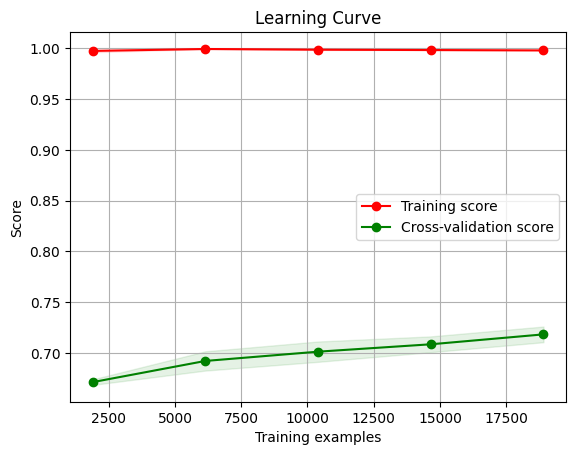

In [12]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    verbose=3,
    random_state=42,
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    color="r",
    alpha=0.1,
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    color="g",
    alpha=0.1,
)

plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.savefig("../plots/learning_curve.png", dpi=300, bbox_inches="tight")
plt.show()


In [13]:
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()

print("Model trained in {:.2f} seconds".format(end_time - start_time))
pipeline

Model trained in 173.87 seconds

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('release_date',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function release_date_name at 0x00000170CAF3E160>,
                                                                                       func=<function release_date at 0x00000170CA703B80>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'track_album_release_date'),
                                                 ('r...
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(random_state=42),
                                    n_jobs=-1, verbose=2))])

In [14]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


precision    recall  f1-score   support

           0       0.76      0.81      0.78      3453
           1       0.70      0.63      0.66      2456

    accuracy                           0.74      5909
   macro avg       0.73      0.72      0.72      5909
weighted avg       0.73      0.74      0.73      5909

In [15]:
print("Performance on validation set:")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

Performance on validation set:

Accuracy: 0.7353190049077678

Precision: 0.7018099547511312

Recall: 0.631514657980456

F1: 0.6648092584654951

ROC AUC: 0.7203330602384179

## Performance on unseen data


In [16]:
test_data = pd.read_csv("../data/spotify_songs_isolated_sample.csv")
test_X, test_Y = (
    test_data.drop(columns=["track_popularity"]),
    (test_data["track_popularity"] > 50).astype(int),
)

test_Y_pred = pipeline.predict(test_X)

print(classification_report(test_Y, test_Y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


precision    recall  f1-score   support

           0       0.75      0.82      0.78      1882
           1       0.72      0.63      0.67      1401

    accuracy                           0.74      3283
   macro avg       0.73      0.72      0.73      3283
weighted avg       0.74      0.74      0.73      3283

In [17]:
print("Performance on test set:")
print(f"Accuracy: {accuracy_score(test_Y, test_Y_pred)}")
print(f"Precision: {precision_score(test_Y, test_Y_pred)}")
print(f"Recall: {recall_score(test_Y, test_Y_pred)}")
print(f"F1: {f1_score(test_Y, test_Y_pred)}")
print(f"ROC AUC: {roc_auc_score(test_Y, test_Y_pred)}")

Performance on test set:

Accuracy: 0.7380444715199512

Precision: 0.7230008244023083

Recall: 0.6259814418272662

F1: 0.6710022953328233

ROC AUC: 0.7237239834003495

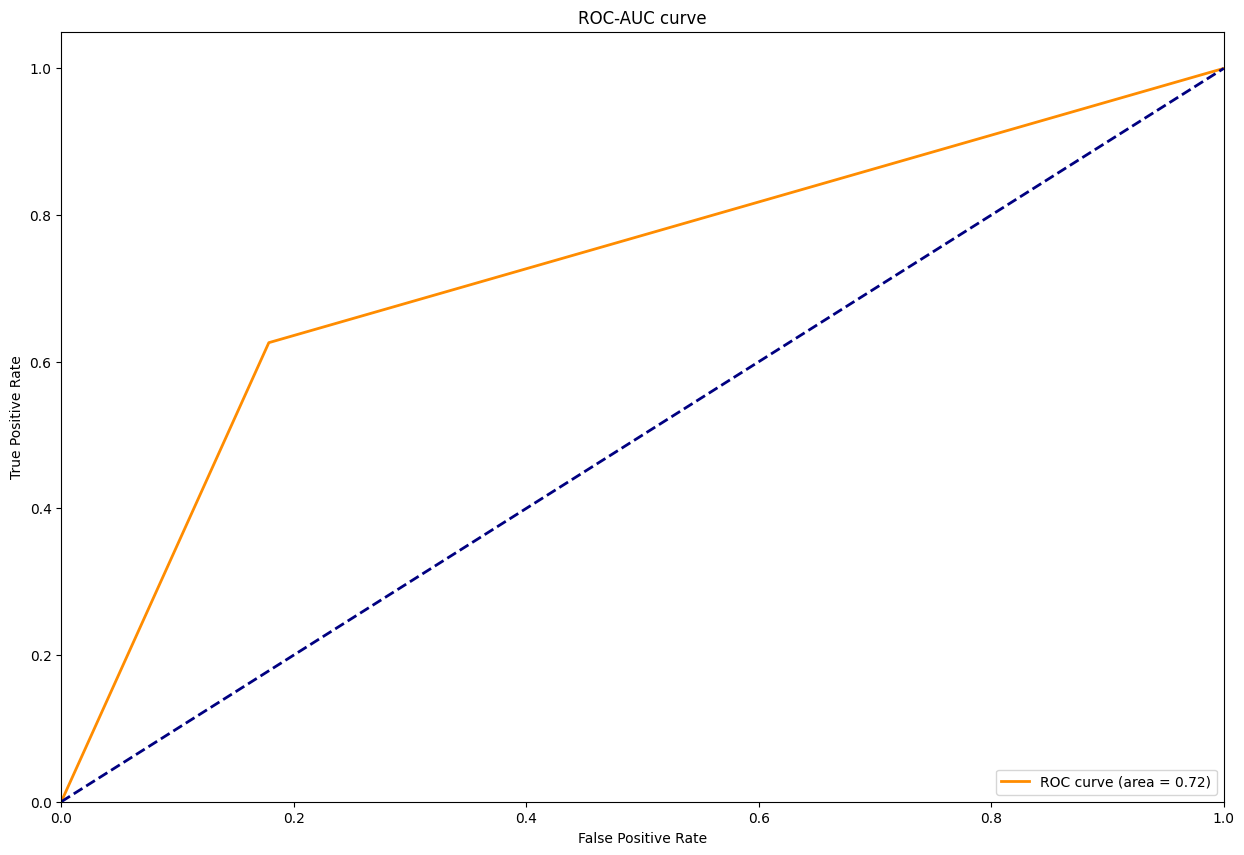

In [18]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_Y, test_Y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 10))
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC curve")
plt.legend(loc="lower right")

plt.savefig("../plots/roc_auc_curve.png", dpi=300, bbox_inches="tight")

plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


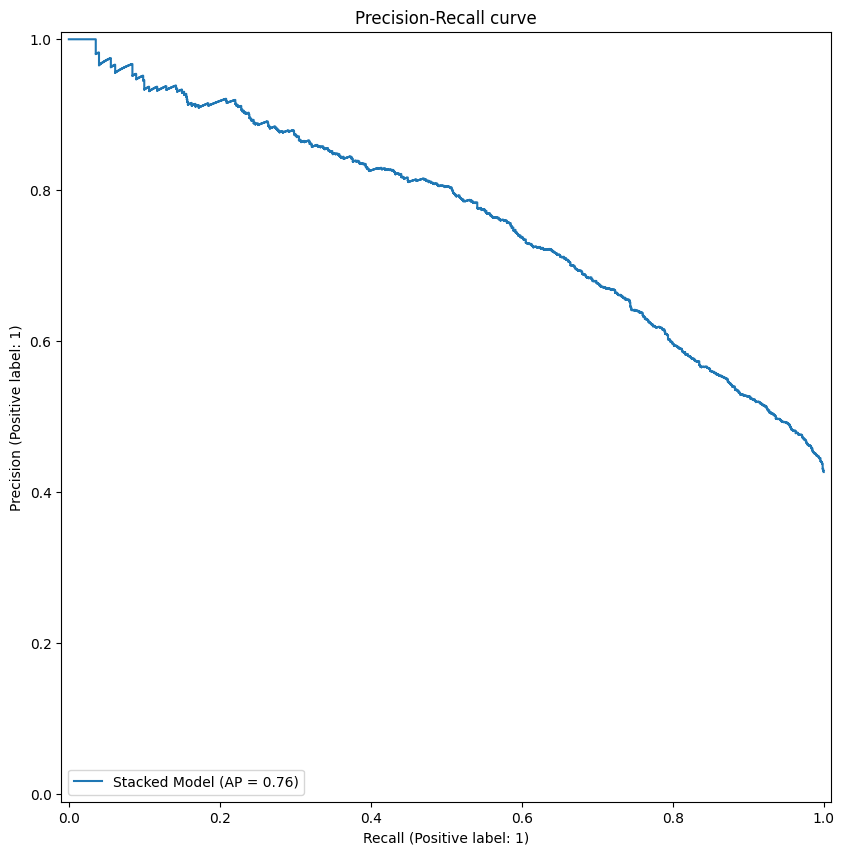

In [19]:
# Plot Precision-Recall curve
pr_curve = PrecisionRecallDisplay.from_estimator(
    pipeline, test_X, test_Y, name="Stacked Model"
)

_ = pr_curve.ax_.set_title("Precision-Recall curve")
_ = pr_curve.figure_.set_size_inches(15, 10)

pr_curve.figure_.savefig(
    "../plots/precision_recall_curve.png", dpi=300, bbox_inches="tight"
)


## Model comparison


In [20]:
stacked_model_estimators = stacked_model.estimators_
reports = {}

test_X_transformed = pipeline.named_steps["columntransformer"].transform(test_X)


for estimator in stacked_model_estimators:
    print(f"Report for: {estimator.__class__.__name__}")

    pred_Y = estimator.predict(test_X_transformed)

    print(classification_report(test_Y, pred_Y))

    report = {
        "accuracy": accuracy_score(test_Y, pred_Y),
        "precision": precision_score(test_Y, pred_Y),
        "recall": recall_score(test_Y, pred_Y),
        "f1": f1_score(test_Y, pred_Y),
        "roc_auc": roc_auc_score(test_Y, pred_Y),
        "confusion_matrix": confusion_matrix(test_Y, pred_Y),
    }

    reports[estimator.__class__.__name__] = report

Report for: KNeighborsClassifier

precision    recall  f1-score   support

           0       0.70      0.74      0.72      1882
           1       0.62      0.58      0.60      1401

    accuracy                           0.67      3283
   macro avg       0.66      0.66      0.66      3283
weighted avg       0.67      0.67      0.67      3283

Report for: RandomForestClassifier

precision    recall  f1-score   support

           0       0.74      0.83      0.78      1882
           1       0.72      0.60      0.66      1401

    accuracy                           0.73      3283
   macro avg       0.73      0.72      0.72      3283
weighted avg       0.73      0.73      0.73      3283

Report for: GaussianNB

precision    recall  f1-score   support

           0       0.71      0.63      0.67      1882
           1       0.57      0.66      0.61      1401

    accuracy                           0.64      3283
   macro avg       0.64      0.64      0.64      3283
weighted avg       0.65      0.64      0.64      3283

Report for: GradientBoostingClassifier

precision    recall  f1-score   support

           0       0.74      0.80      0.77      1882
           1       0.70      0.63      0.66      1401

    accuracy                           0.73      3283
   macro avg       0.72      0.72      0.72      3283
weighted avg       0.73      0.73      0.73      3283

Report for: DecisionTreeClassifier

precision    recall  f1-score   support

           0       0.69      0.71      0.70      1882
           1       0.60      0.58      0.59      1401

    accuracy                           0.65      3283
   macro avg       0.65      0.64      0.64      3283
weighted avg       0.65      0.65      0.65      3283

Report for: LGBMClassifier

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


precision    recall  f1-score   support

           0       0.74      0.79      0.76      1882
           1       0.69      0.63      0.66      1401

    accuracy                           0.72      3283
   macro avg       0.72      0.71      0.71      3283
weighted avg       0.72      0.72      0.72      3283

Report for: XGBClassifier

precision    recall  f1-score   support

           0       0.74      0.79      0.77      1882
           1       0.69      0.63      0.66      1401

    accuracy                           0.72      3283
   macro avg       0.72      0.71      0.71      3283
weighted avg       0.72      0.72      0.72      3283

In [21]:
y_pred_stacked = pipeline.predict(test_X)

reports["stacked_model"] = {
    "accuracy": accuracy_score(test_Y, y_pred_stacked),
    "precision": precision_score(test_Y, y_pred_stacked),
    "recall": recall_score(test_Y, y_pred_stacked),
    "f1": f1_score(test_Y, y_pred_stacked),
    "roc_auc": roc_auc_score(test_Y, y_pred_stacked),
    "confusion_matrix": confusion_matrix(test_Y, y_pred_stacked),
}

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [22]:
reports = pd.DataFrame(reports).T

In [23]:
reports

accuracy precision    recall        f1   roc_auc  \
KNeighborsClassifier         0.67286  0.624714  0.584582  0.603982  0.661579   
RandomForestClassifier      0.732257  0.723077  0.603854   0.65811  0.715849   
GaussianNB                  0.640877  0.568688   0.65596  0.609214  0.642805   
GradientBoostingClassifier  0.727993  0.702552  0.628837  0.663653  0.715322   
DecisionTreeClassifier      0.653366  0.596056  0.582441   0.58917  0.644302   
LGBMClassifier              0.720987  0.689601   0.62955  0.658209  0.709302   
XGBClassifier               0.722205  0.692368  0.628123  0.658683  0.710183   
stacked_model               0.738044  0.723001  0.625981  0.671002  0.723724   

                                     confusion_matrix  
KNeighborsClassifier        [[1390, 492], [582, 819]]  
RandomForestClassifier      [[1558, 324], [555, 846]]  
GaussianNB                  [[1185, 697], [482, 919]]  
GradientBoostingClassifier  [[1509, 373], [520, 881]]  
DecisionTreeClassifier      [[1329, 553], [585, 816]]  
LGBMClassifier              [[1485, 397], [519, 882]]  
XGBClassifier               [[1491, 391], [521, 880]]  
stacked_model               [[1546, 336], [524, 877]]

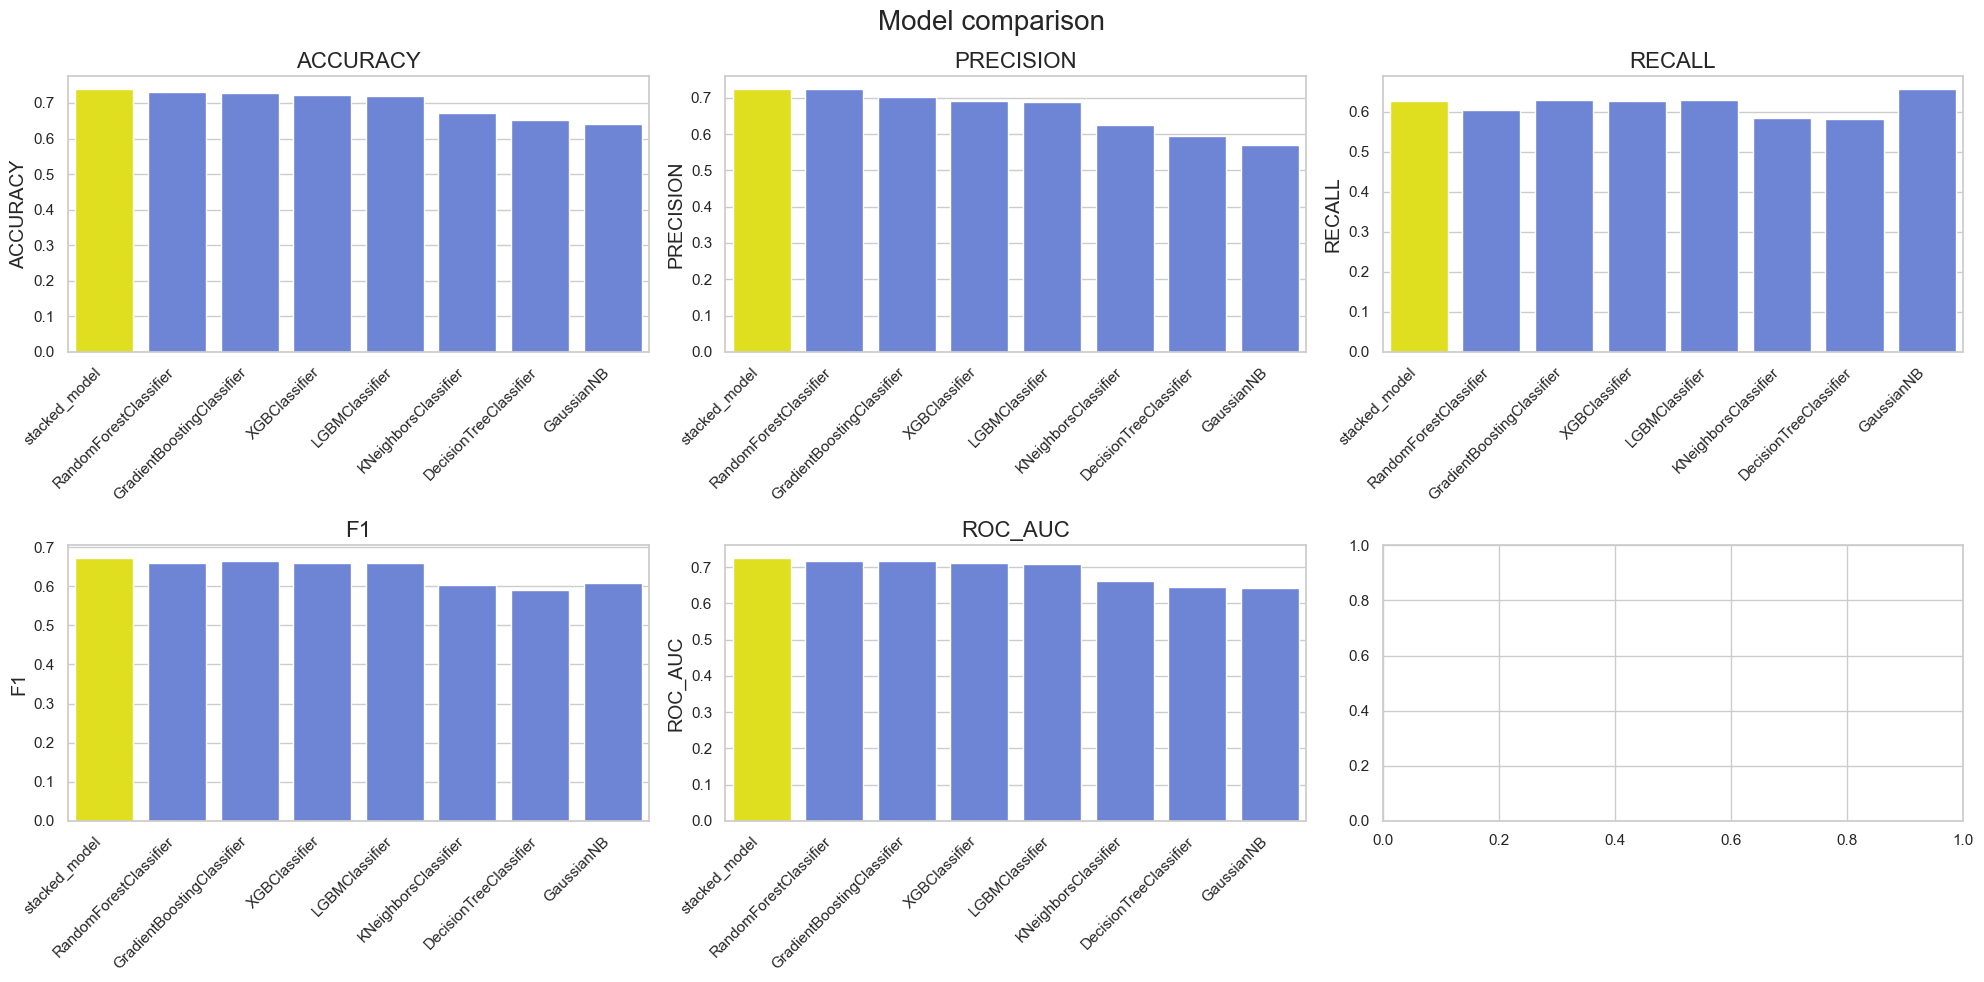

In [24]:
# Set the aesthetics for the plots
sns.set_theme(style="whitegrid")

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), constrained_layout=True)
axs = axs.flatten()[:-1]  # Use only 5 subplots, ignore the last one

# Determine the order of x labels based on the first metric to ensure consistency across all plots
sorted_index = reports["accuracy"].sort_values(ascending=False).index

# Define a color palette
# Use a single color for all but the stacked_model, which will be highlighted in a different color
base_color = sns.color_palette("coolwarm", len(sorted_index))[
    0
]  # Use the first color for all
highlight_color = "yellow"  # Highlight color for the stacked_model
palette = [
    highlight_color if model == "stacked_model" else base_color
    for model in sorted_index
]

# Plot each metric for each model
for i, metric in enumerate(["accuracy", "precision", "recall", "f1", "roc_auc"]):
    sns.barplot(
        x=sorted_index, y=reports.loc[sorted_index, metric], ax=axs[i], palette=palette
    )
    axs[i].set_title(metric.upper(), fontsize=16)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")
    axs[i].set_ylabel(metric.upper(), fontsize=14)
    axs[i].set_xlabel("")

# Adjust layout and add a tight layout to manage space
plt.suptitle("Model comparison", fontsize=20)
plt.tight_layout()

plt.savefig("../plots/model_comparison.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

## Hyperparameter tuning

We present the code for hyperparameter tuning here. The actual tuning was done on a Colab notebook.


In [ ]:
## Takes a long time to run, please be patient...

# Initialize pipelines dictionary
pipelines = {}
for name, estimator in estimators:
    pipelines[name] = Pipeline(
        [("feature_engg", feature_engineering), (name, estimator)]
    )

# Updated parameter grids, organized by estimator key
param_grid = {
    "knn": {
        "knn__n_neighbors": [3, 5, 7, 10],
        "knn__weights": ["uniform", "distance"],
        "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    },
    "rf": {
        "rf__n_estimators": [100, 200, 300, 400],
        "rf__max_depth": [10, 20, 30],
        "rf__min_samples_split": [2, 5, 10],
    },
    "gnb": {
        "gnb__var_smoothing": [1e-9, 1e-8, 1e-10],
    },
    "gbc": {
        "gbc__n_estimators": [100, 200, 300],
        "gbc__learning_rate": [0.01, 0.1, 0.2],
        "gbc__max_depth": [3, 5, 7],
    },
    "dt": {
        "dt__max_depth": [10, 20, 30],
        "dt__min_samples_split": [2, 5, 10],
        "dt__min_samples_leaf": [1, 2, 4],
    },
    "lgb": {
        "lgb__n_estimators": [100, 500, 1000],
        "lgb__learning_rate": [0.01, 0.1, 0.5],
        "lgb__max_depth": [3, 5, 7, 10],
    },
    "xgb": {
        "xgb__n_estimators": [100, 500, 1000],
        "xgb__learning_rate": [0.01, 0.1, 0.5],
        "xgb__max_depth": [3, 5, 7, 10],
    },
}

searches = {}

for name, pipeline in pipelines.items():
    # Retrieve the parameter grid for the current estimator
    estimator_param_grid = param_grid[name]

    search = GridSearchCV(
        estimator=pipeline,
        param_grid=estimator_param_grid,
        scoring="accuracy",  # Use 'f1' for scoring, consider 'f1_macro' or 'f1_weighted' for multi-class
        n_jobs=-1,
        cv=5,
        verbose=2,
    )

    searches[name] = search

results = []

# Fit each search object to perform hyperparameter tuning for each pipeline and collect results
for name, search in searches.items():
    print(f"Starting GridSearchCV for {name}...")
    search.fit(X_train, y_train)  # Ensure X_train and y_train are defined
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best score for {name}: {search.best_score_}")

    # Append the results to the list
    results.append(
        {
            "Model": name,
            "Best Parameters": search.best_params_,
            "Best Score": search.best_score_,
        }
    )

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

## Model explainability

We use SHAP to explain the feature importance from the stacked classifier model.


In [25]:
shap.initjs()

explainer = shap.KernelExplainer(
    pipeline.named_steps["stackingclassifier"].predict_proba,
    shap.sample(
        pipeline.named_steps["columntransformer"].transform(X_train),
        10000,
        random_state=42,
    ),
    nsamples=100,
    link="logit",
)

<IPython.core.display.HTML object>

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [26]:
X_test_transformed = pipeline.named_steps["columntransformer"].transform(test_X)

# Calculate SHAP values
# Takes a very long time to run - please be patient...

shap_values = explainer.shap_values(
    shap.sample(
        X_test_transformed,
        10,
        random_state=42,
    ),
    nsamples=100,
    gc_collect=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 10%|█         | 1/10 [02:38<23:44, 158.24s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 20%|██        | 2/10 [04:53<19:19, 144.90s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 30%|███       | 3/10 [07:04<16:07, 138.26s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 40%|████      | 4/10 [09:18<13:40, 136.80s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 50%|█████     | 5/10 [11:33<11:20, 136.00s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 60%|██████    | 6/10 [13:49<09:04, 136.20s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 70%|███████   | 7/10 [16:03<06:45, 135.21s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 80%|████████  | 8/10 [18:19<04:30, 135.50s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 90%|█████████ | 9/10 [20:31<02:14, 134.35s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


100%|██████████| 10/10 [22:41<00:00, 136.17s/it]


In [27]:
explainer.expected_value

array([ 0.24355804, -0.24355804])

In [28]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][4, :],
    pd.DataFrame(
        X_test_transformed,
        columns=pipeline.named_steps["columntransformer"].get_feature_names_out(),
    ).iloc[4, :],
    link="logit",
)


<shap.plots._force.AdditiveForceVisualizer object at 0x00000170CC920F10>

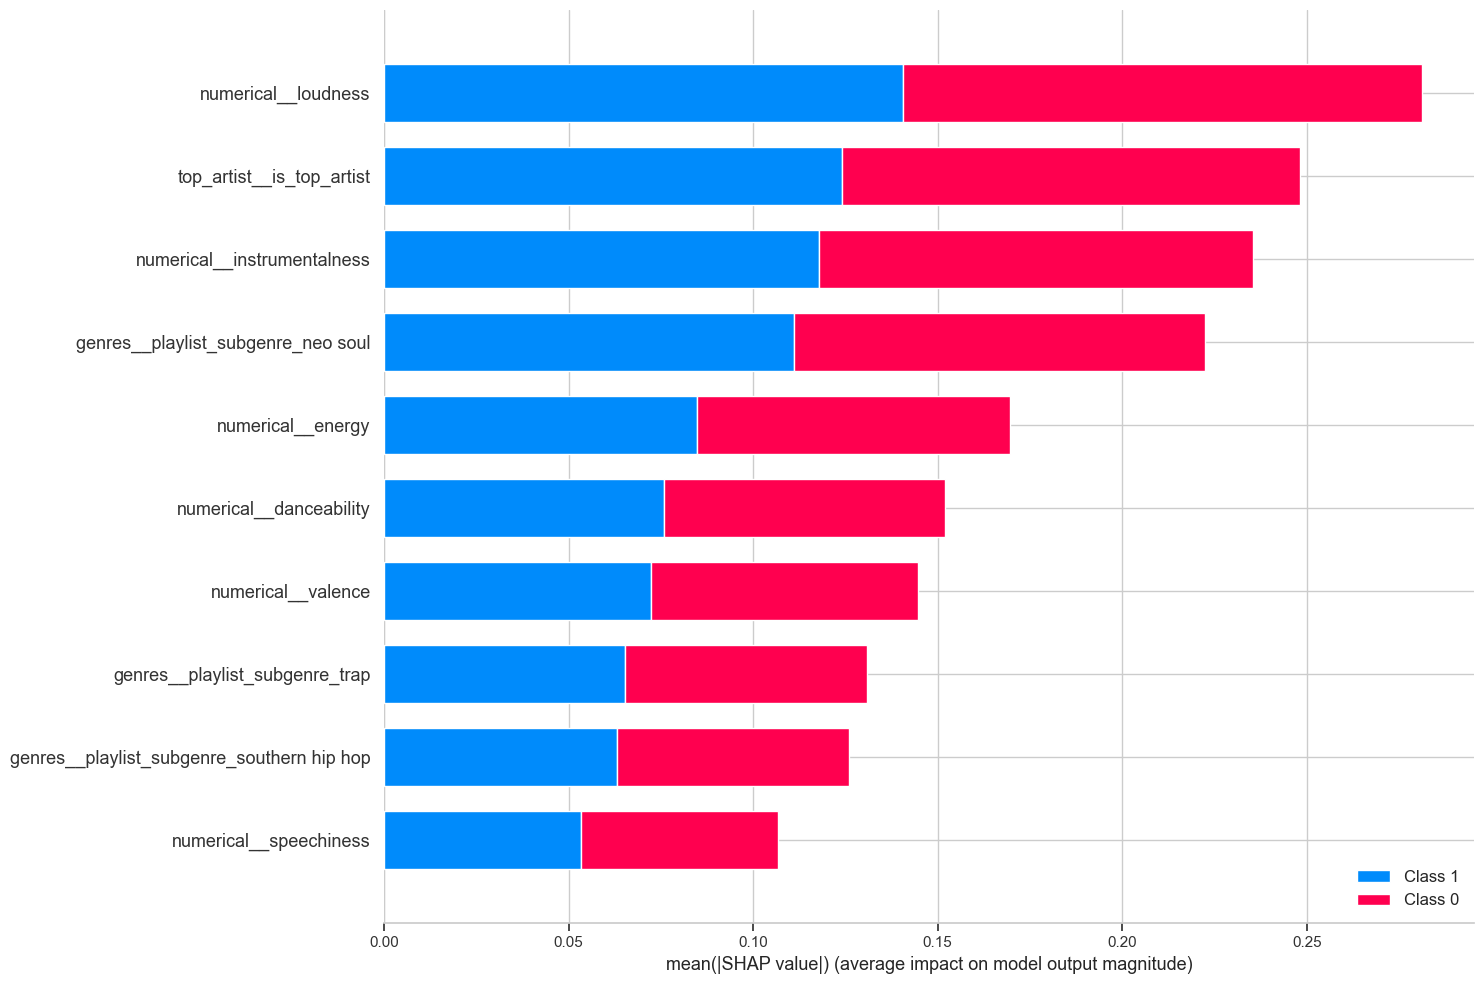

In [29]:
shap.summary_plot(
    shap_values,
    pd.DataFrame(
        shap.sample(
            X_test_transformed,
            10,
            random_state=42,
        ),
        columns=pipeline.named_steps["columntransformer"].get_feature_names_out(),
    ),
    title="SHAP Summary Plot",
    plot_type="bar",
    max_display=10,
    plot_size=(15, 10),
)
